### Final Course Assignment Part 2

Flight delays are disruptive to travel plans and cause significant direct and indirect costs to passengers and airline companies. United Airlines approached you with a request to help them understand the causes and predict the occurrences of flight delays in order to in order to help them better cope with flight delays. Airlines and transportation authorities have been paying close attention to flight delays over the years and collected detailed information of flight delays of all commercial flights. The file contains information on nonstop United Airlines flights during December 2015. This dataset was obtained from http://www.transtats.bts.gov and went through some preliminary preprocessing for this projects. The dataset contains 11 columns listed below.

    CARRIER: Code assigned by IATA to identify a carrier. Since all flights belong to United Airlines, this column only takes value “UA.”
    YEAR: year of the flight
    MONTH: month of the flight
    DAY_OF_MONTH: day of the month
    DAY_OF_WEEK: day of the week
    ORIGIN: origin airport code
    DEST: destination airport code
    CRS_DEP_TIME: scheduled departure time (number of minutes since 12:00AM)
    CRS_ARR_TIME: scheduled arrival time (number of minutes since 12:00AM)
    ARR_DELAY: Difference in minutes between scheduled and actual arrival time. Early arrivals show negative numbers.
    ARR_DEL15: Arrival Delay Indicator, 15 Minutes or More (1=Yes).
    CRS_ELAPSED_TIME: scheduled flight duration (in minutes)
    ACTUAL_ELAPSED_TIME: actual flight time (in minutes)
    DISTANCE: distance between airports.

Part 1.2 Create a plot to show an interesting aspect of the data. For this part of the assignment, you can use Excel or another visualization software (such as Tableau) to create a plot. Upload a screenshot or picture of the plot.

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import to_graphviz, plot_importance

%matplotlib inline
sns.set_style('dark')
sns.set(font_scale=1.2)

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, accuracy_score
from sklearn.metrics import auc, f1_score, precision_score, recall_score, roc_auc_score


#import feature_engine.missing_data_imputers as mdi
#from feature_engine.outlier_removers import Winsorizer

#from tpot import TPOTClassifier, TPOTRegressor
#from imblearn.under_sampling import RandomUnderSampler
#from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings('ignore')

import pickle
from pickle import dump, load

np.random.seed(0)

#from pycaret.classification import *
#from pycaret.clustering import *
#from pycaret.regression import *

pd.set_option('display.max_columns',100)
#pd.set_option('display.max_rows',100)
pd.set_option('display.width', 1000)

### Data Exploration and Analysis

In [2]:
df = pd.read_csv("delay-UA-cleaned.csv")

In [3]:
df

,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_DEP_TIME,CRS_ARR_TIME,ARR_DELAY,ARR_DEL15,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE
0,31,4,SFO,DEN,1418,1758,-31,0,160,137,967
1,31,4,DEN,IAH,1601,1926,9,0,145,134,862
2,31,4,ORD,DEN,1600,1748,36,1,168,155,888
3,31,4,ORD,SFO,1241,1531,7,0,290,291,1846
4,31,4,IAH,SFO,1852,2114,-6,0,262,250,1635
...,...,...,...,...,...,...,...,...,...,...,...
3895,3,4,SFO,IAH,555,1149,-22,0,234,217,1635
3896,3,4,SFO,IAH,1251,1833,36,1,222,219,1635
3897,3,4,IAH,SFO,1602,1824,121,1,262,262,1635
3898,3,4,SFO,ORD,1907,114,29,1,247,244,1846


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   DAY_OF_MONTH         3900 non-null   int64 
 1   DAY_OF_WEEK          3900 non-null   int64 
 2   ORIGIN               3900 non-null   object
 3   DEST                 3900 non-null   object
 4   CRS_DEP_TIME         3900 non-null   int64 
 5   CRS_ARR_TIME         3900 non-null   int64 
 6   ARR_DELAY            3900 non-null   int64 
 7   ARR_DEL15            3900 non-null   int64 
 8   CRS_ELAPSED_TIME     3900 non-null   int64 
 9   ACTUAL_ELAPSED_TIME  3900 non-null   int64 
 10  DISTANCE             3900 non-null   int64 
dtypes: int64(9), object(2)
memory usage: 335.3+ KB


In [5]:
df.describe(include='all')

,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_DEP_TIME,CRS_ARR_TIME,ARR_DELAY,ARR_DEL15,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE
count,3900.000000,3900.000000,3900,3900,3900.000000,3900.000000,3900.000000,3900.000000,3900.000000,3900.000000,3900.000000
unique,NaN,NaN,5,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,ORD,ORD,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,1039,1006,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,16.311538,3.833846,NaN,NaN,1290.533590,1483.321538,16.473846,0.271795,195.116154,185.358462,1209.643333
std,8.900471,1.931657,NaN,NaN,495.171511,533.152880,68.702003,0.444942,51.978689,53.113724,413.571785
min,1.000000,1.000000,NaN,NaN,7.000000,1.000000,-56.000000,0.000000,75.000000,67.000000,264.000000
25%,9.000000,2.000000,NaN,NaN,905.000000,1142.000000,-15.000000,0.000000,155.000000,143.000000,888.000000
50%,17.000000,4.000000,NaN,NaN,1252.000000,1524.500000,-4.000000,0.000000,168.000000,161.000000,967.000000
75%,24.000000,5.000000,NaN,NaN,1701.250000,1912.000000,19.000000,1.000000,252.000000,234.000000,1635.000000


In [6]:
df.shape

(3900, 11)

### Data Exploration

In [7]:
df.columns

Index(['DAY_OF_MONTH', 'DAY_OF_WEEK', 'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'ARR_DELAY', 'ARR_DEL15', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'DISTANCE'], dtype='object')

In [8]:
df['DAY_OF_MONTH'].value_counts()

18    153
21    150
22    148
23    148
17    145
30    142
29    139
20    134
27    131
1     130
11    129
26    129
3     129
10    129
7     127
16    126
14    125
19    124
2     121
9     120
8     120
4     120
28    118
31    118
6     116
13    115
15    113
24    112
25    105
5      92
12     92
Name: DAY_OF_MONTH, dtype: int64

In [9]:
df['DAY_OF_WEEK'].value_counts()

3    657
2    650
4    633
1    520
5    507
7    496
6    437
Name: DAY_OF_WEEK, dtype: int64

In [10]:
df['ORIGIN'].value_counts()

ORD    1039
SFO     970
IAH     946
DEN     942
CVG       3
Name: ORIGIN, dtype: int64

In [11]:
df['DEST'].value_counts()

ORD    1006
SFO     996
IAH     951
DEN     947
Name: DEST, dtype: int64

In [12]:
df['CRS_DEP_TIME'].value_counts()

600     88
1015    64
530     60
1735    50
715     45
        ..
1256     1
827      1
831      1
835      1
12       1
Name: CRS_DEP_TIME, Length: 569, dtype: int64

In [13]:
df['CRS_ARR_TIME'].value_counts()

1700    34
1159    33
1748    33
1156    30
2035    30
        ..
1637     1
903      1
349      1
1438     1
1639     1
Name: CRS_ARR_TIME, Length: 703, dtype: int64

In [14]:
df['ARR_DELAY'].value_counts()

-8       97
-13      97
-15      97
-10      96
-12      96
         ..
 336      1
 324      1
 322      1
 304      1
 1069     1
Name: ARR_DELAY, Length: 307, dtype: int64

In [15]:
df['ARR_DEL15'].value_counts()

0    2840
1    1060
Name: ARR_DEL15, dtype: int64

In [16]:
df.columns

Index(['DAY_OF_MONTH', 'DAY_OF_WEEK', 'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'ARR_DELAY', 'ARR_DEL15', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'DISTANCE'], dtype='object')

In [17]:
df['CRS_ELAPSED_TIME'].value_counts()

168    145
153    129
163    126
160    125
154    112
      ... 
282      1
274      1
275      1
270      1
132      1
Name: CRS_ELAPSED_TIME, Length: 121, dtype: int64

In [18]:
df['ACTUAL_ELAPSED_TIME'].value_counts()

142    82
141    76
146    75
148    72
134    70
       ..
332     1
328     1
322     1
320     1
113     1
Name: ACTUAL_ELAPSED_TIME, Length: 225, dtype: int64

In [19]:
df['DISTANCE'].value_counts()

1846    810
862     699
925     623
888     609
967     581
1635    575
264       3
Name: DISTANCE, dtype: int64

### Data Visualization

### Univariate Data Exploration

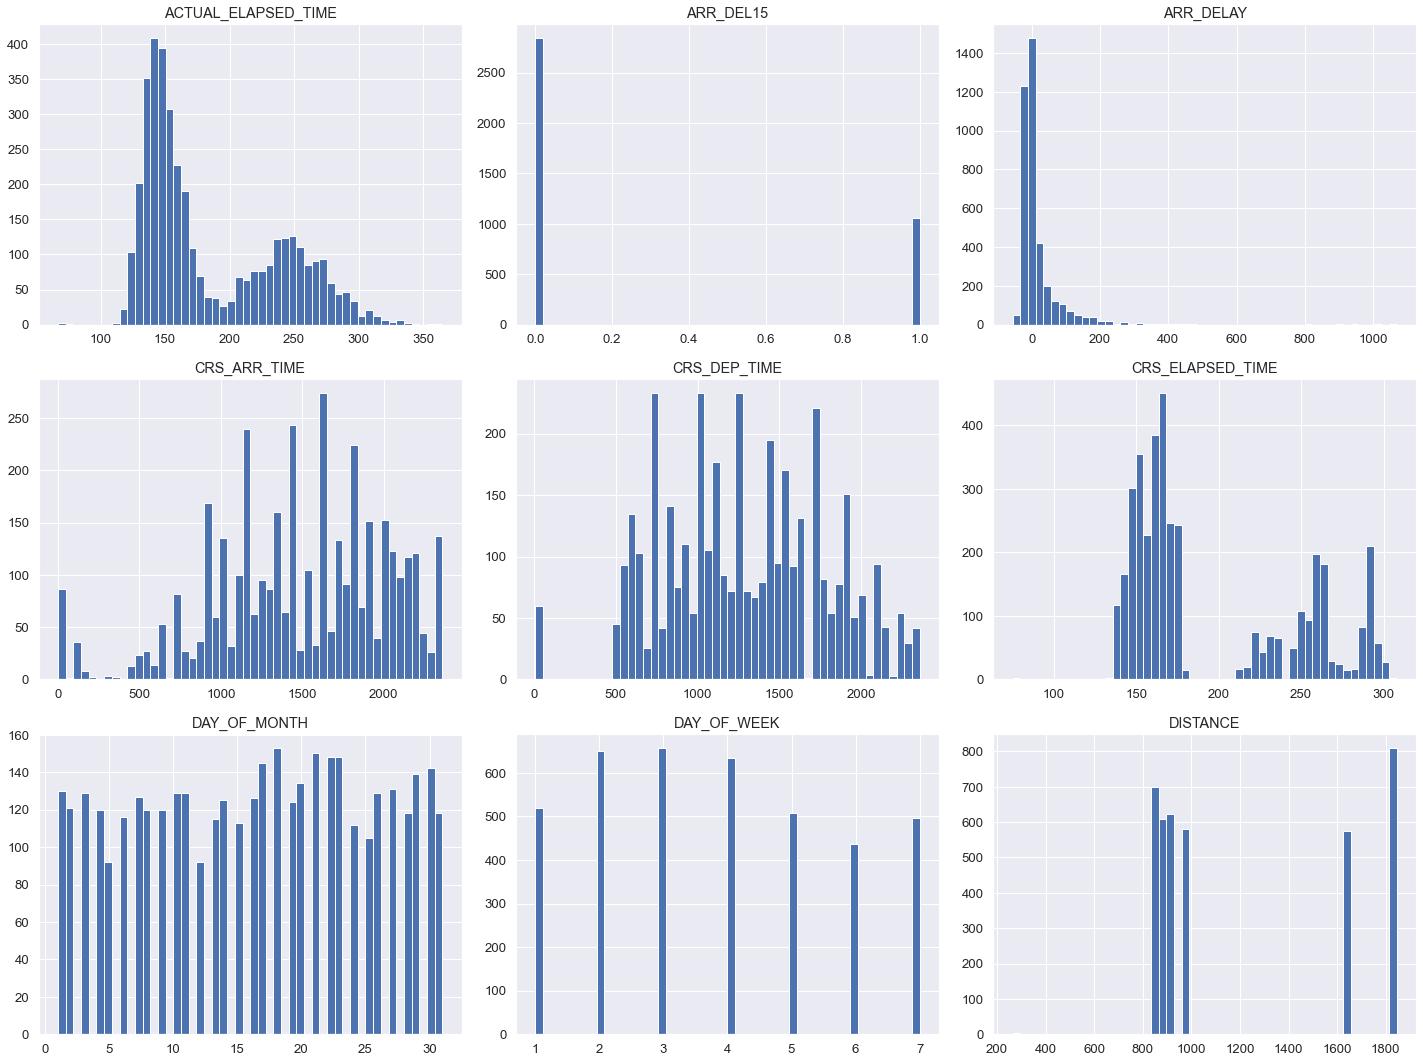

In [20]:
df.hist(bins=50, figsize=(20,15))
plt.tight_layout()
plt.show()

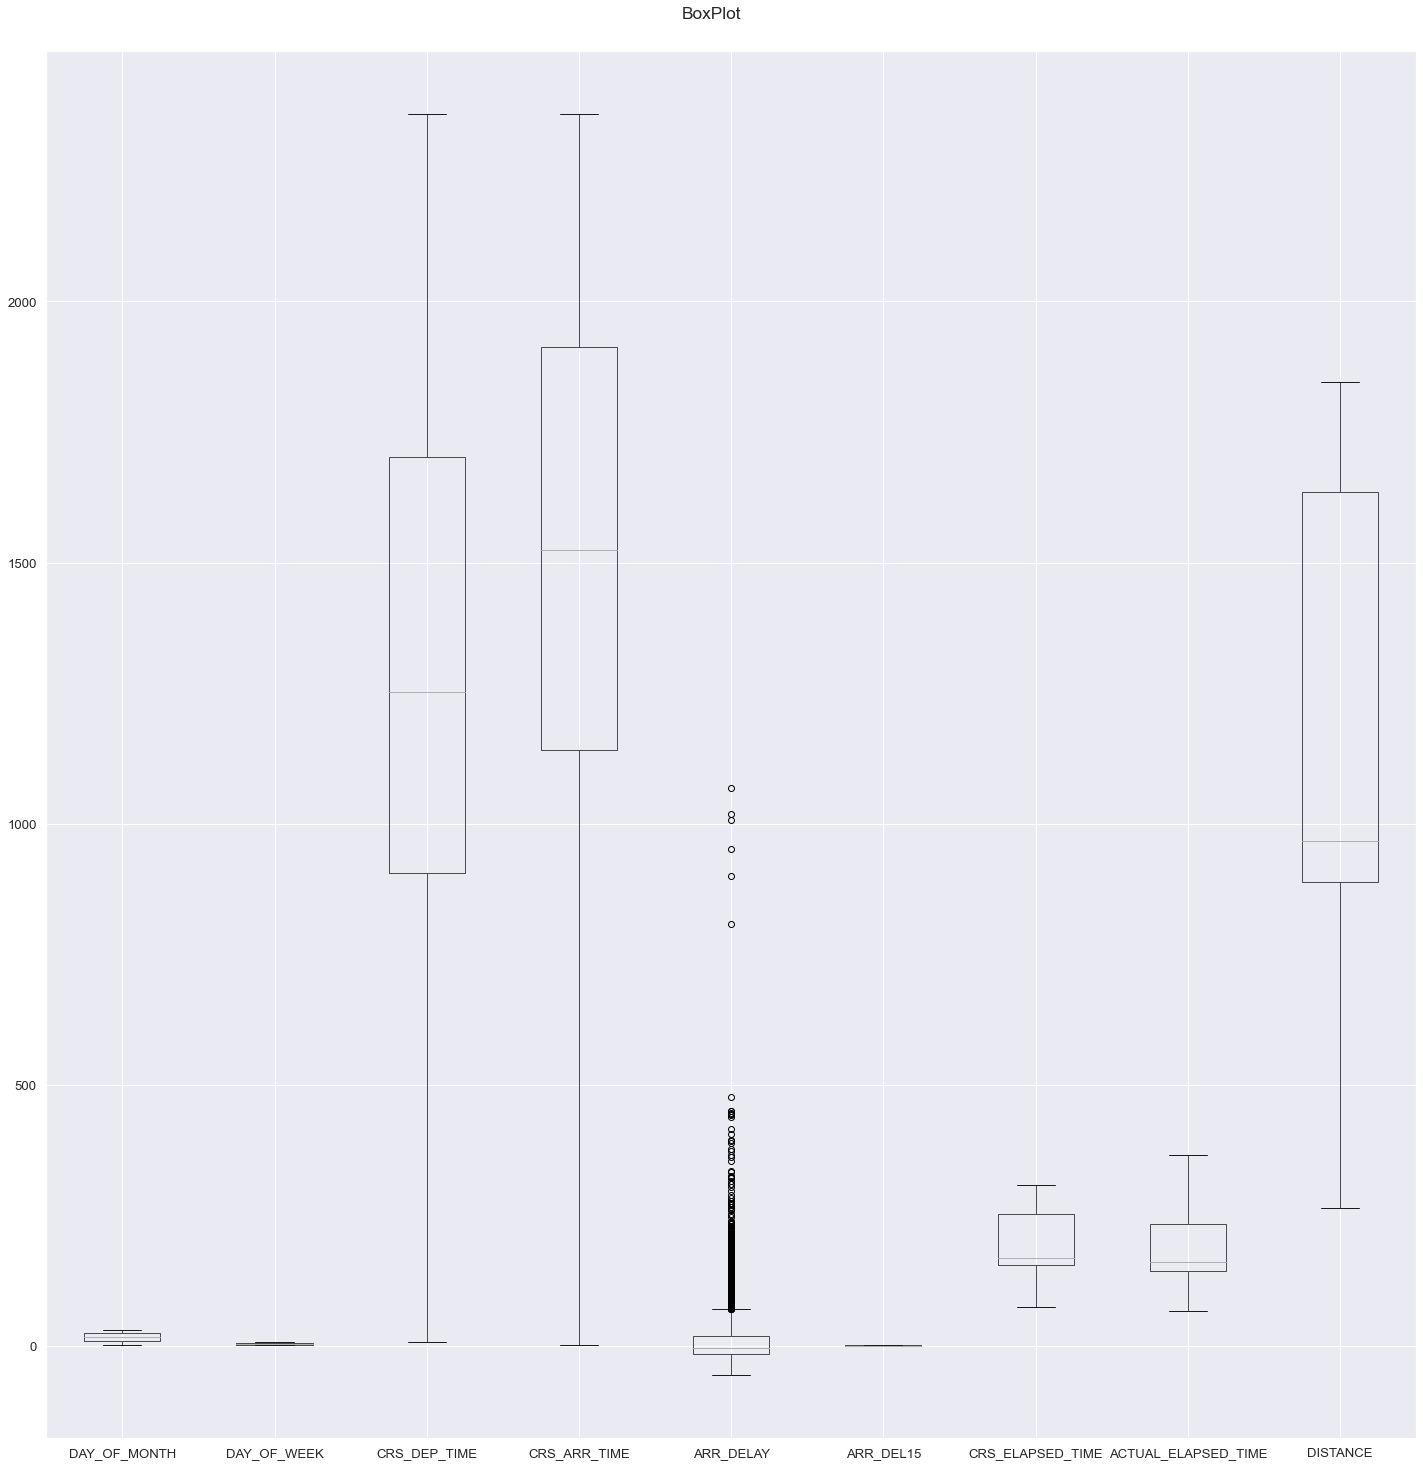

In [21]:
df.boxplot(figsize=(20,20))

plt.suptitle('BoxPlot', x=0.5, y=1.02, ha='center', fontsize='large')

plt.tight_layout()

plt.show()

In [22]:
df.columns

Index(['DAY_OF_MONTH', 'DAY_OF_WEEK', 'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'ARR_DELAY', 'ARR_DEL15', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'DISTANCE'], dtype='object')

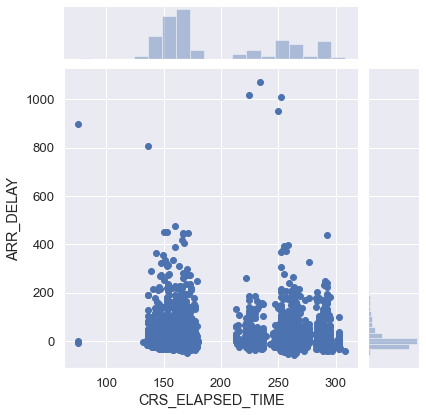

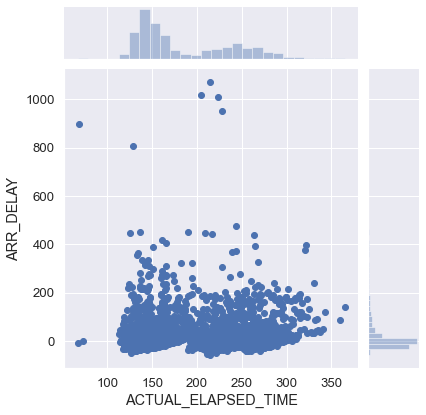

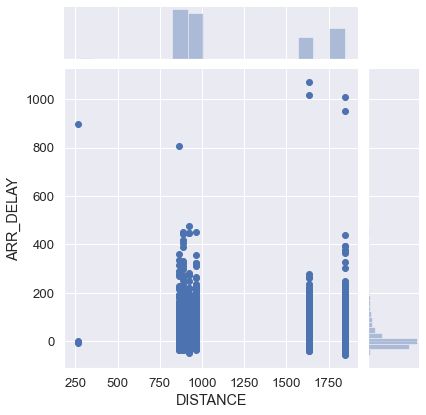

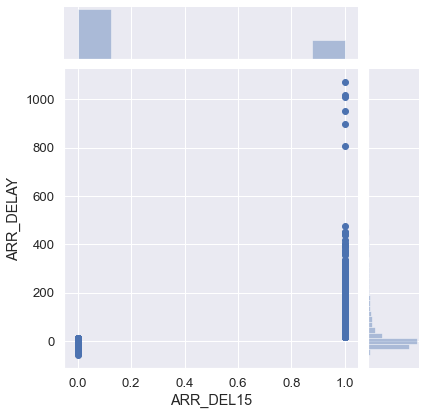

In [23]:
sns.jointplot(x='CRS_ELAPSED_TIME', y='ARR_DELAY',data=df, kind='scatter')

sns.jointplot(x='ACTUAL_ELAPSED_TIME', y='ARR_DELAY',data=df, kind='scatter')

sns.jointplot(x='DISTANCE', y='ARR_DELAY',data=df, kind='scatter')

sns.jointplot(x='ARR_DEL15', y='ARR_DELAY',data=df, kind='scatter')

# sns.jointplot(x='', y='',data=df, kind='kde')

# sns.jointplot(x='', y='',data=df, kind='kde')

# sns.jointplot(x='', y='',data=df, kind='hex')

# sns.jointplot(x='', y='',data=df, kind='hex')

# sns.jointplot(x='', y='',data=df, kind='reg')

# sns.jointplot(x='', y='',data=df, kind='reg')


plt.show()

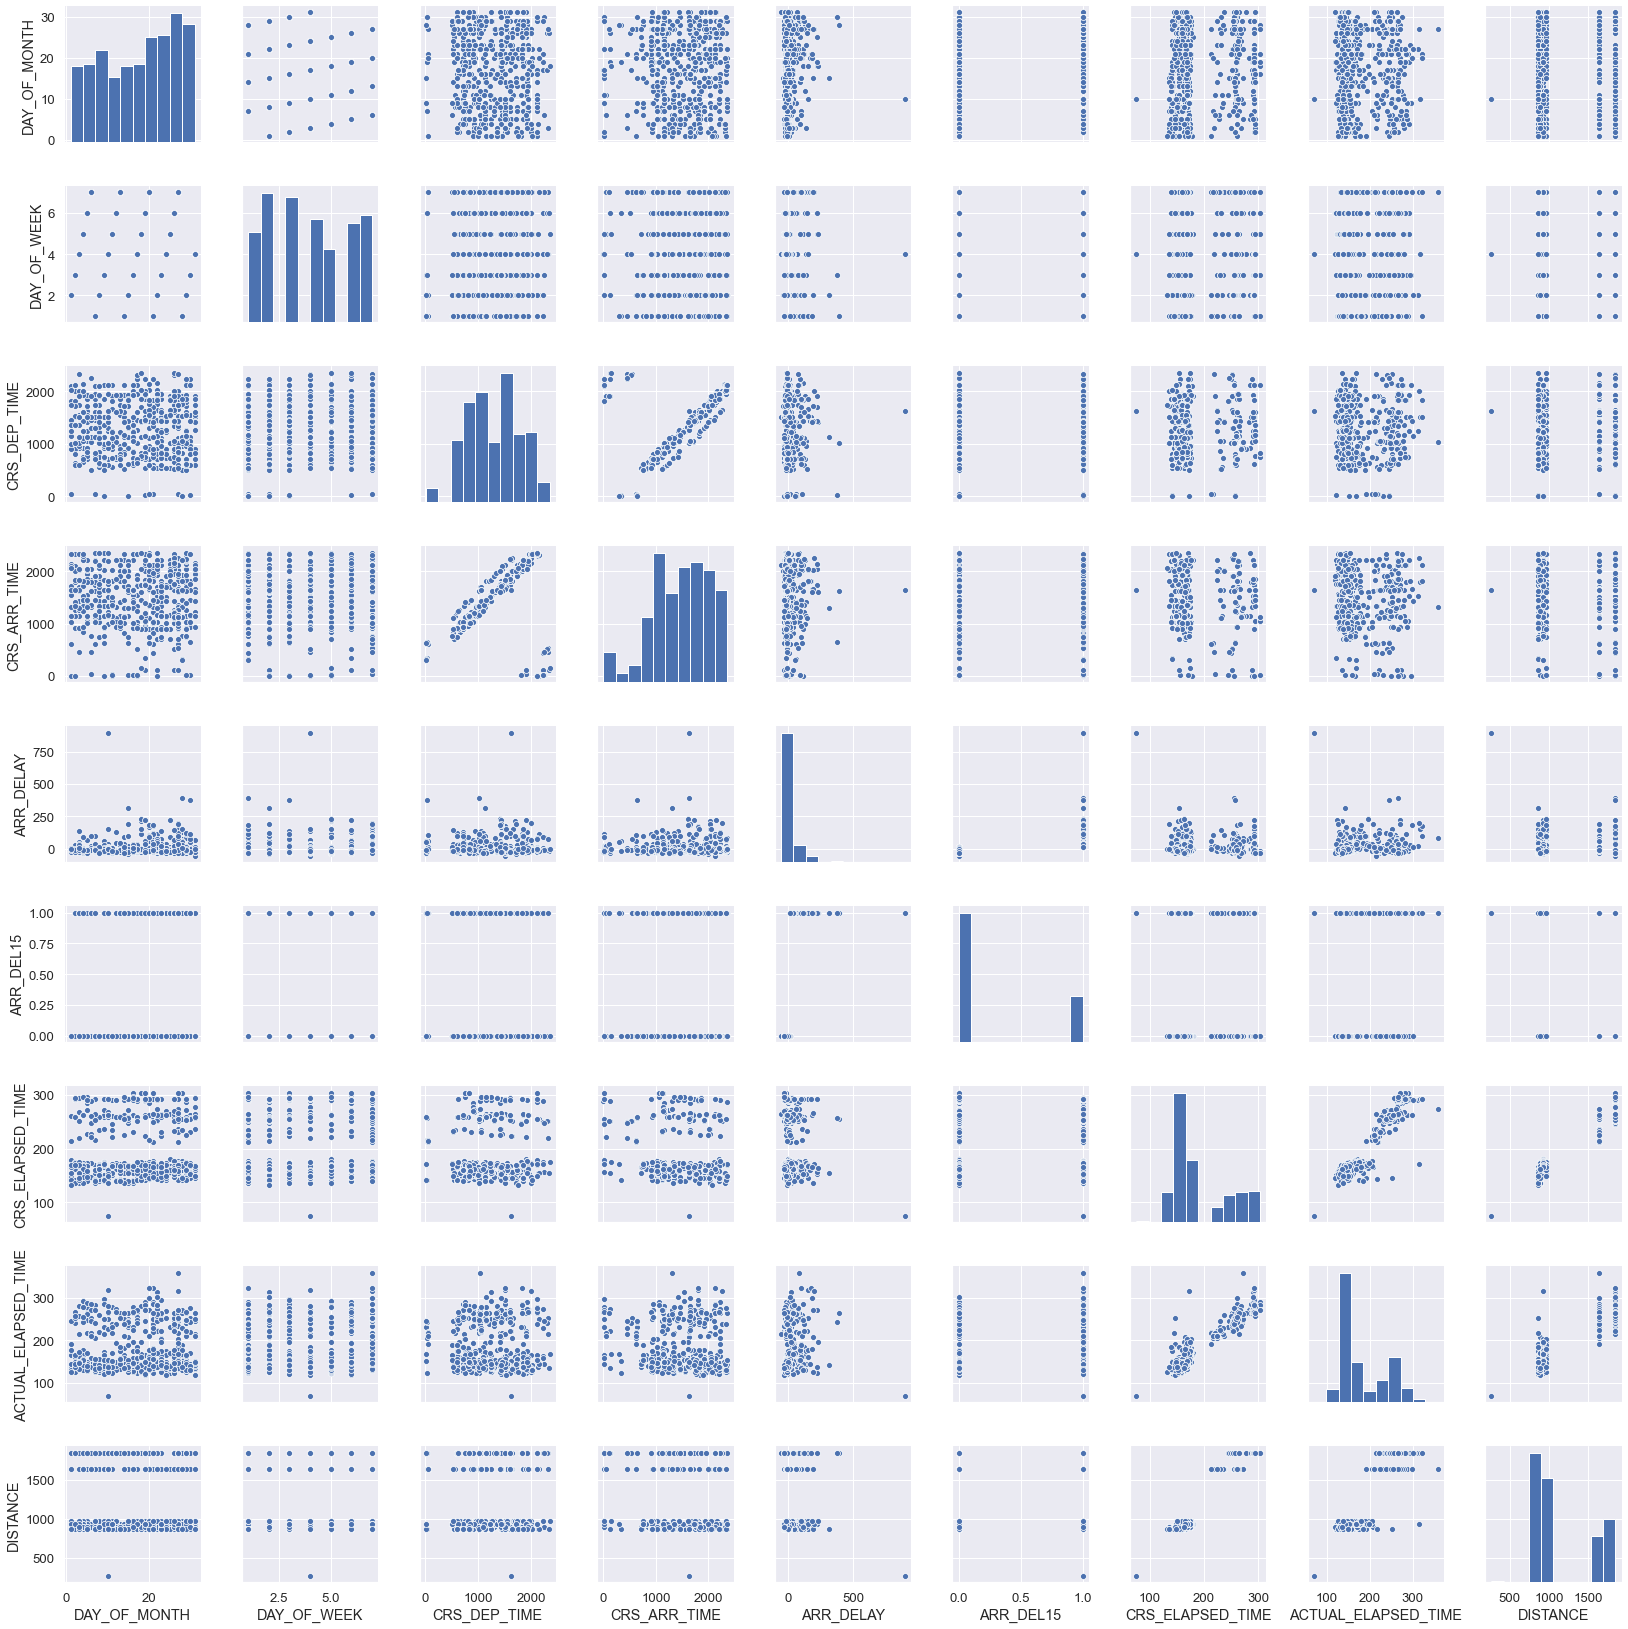

In [24]:
sns.pairplot(df.sample(500))
plt.show()